<a href="https://colab.research.google.com/github/victordibia/taxi/blob/main/notebooks/taxi_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q -U geopandas contextily sklearn

     |████████████████████████████████| 972kB 3.6MB/s 
     |████████████████████████████████| 14.8MB 305kB/s 
     |████████████████████████████████| 6.5MB 28.7MB/s 
     |████████████████████████████████| 18.3MB 238kB/s 


## Taxi Prediction 

Given data on NY Taxi trips explore the following:

- Visualizations and analytics that help end users build intuition on traffic patterns 
- Predict interesting outcomes given data available at test time. E.g. predict trip time or trip fare given date, start/end location etc. 


## Data Download
- Data Sourece - [NYC Taxi Cab](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page)
- [Data Dictionary](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)
- Download data for the last 2 years perhaps
- Train test construction
  - Load data for last 2 years
  - For each month, sample some values 
  - Concatenate samples
- Preprocess data
  - Remove trips with negative fare
  - Remove trips with negative duration
  - Remove trips with null values (we probably have enough data) 
  - Verify column types are correct i.e. categorical for categorical columns.

## Analytics
- Show plot of drop offs and/or pick ups 
- Aggregratedd traffic by time of day over the last month.
- Average time from one location to another? heatmap ?

### Pre-Computations
- From each start location, average time to all other end locations. For each hour during the day. 

## Modeling

- Explore multiple models
  - Naive bayes
  - Decision Tree
  - Random Forest
  - Gradient Boosted Trees
  - Neural Network

## Limitations

- Model limited to input ranges seen in training data e.g. if vendorid is used to train model and new vendorids are introduced, model will need to be updated. 
- External events or data may influence outcomes e.g. holidays, disasters, weather etc. We probably can integrate holiday data.
- The data does not give exact longitude/latitude of pickup and dropoff for privacy reasons. It only says the location ID (boroughs), so predictions are not granular/precise. 


## Download Data

- Ingest sample data from NY Yellow Cab Taxi Data

In [ ]:
import urllib.request 
import zipfile
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar


def mkdir(dir_path):
  os.makedirs(dir_path, exist_ok=True)

def download_file(url, file_path):
  try:
    urllib.request.urlretrieve(url, file_path)
  except:
    print("Unable to download file", url)

def download_taxi_csv(year, month):
  file_url = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_" + str(year) + "-" + str(month) + ".csv" 
  file_path = "data/" + str(year)+ "_" + str(month) + ".csv"
  if not os.path.isfile(file_path):
    download_file(file_url, file_path )

def setup_plot():
  plt.rcParams["axes.grid.axis"] ="y"
  plt.rcParams["axes.grid"] = True
  plt.rcParams["legend.fontsize"] = 14
  plt.rc('grid', linestyle="dashed", color='lightgrey', linewidth=1)
  plt.rcParams["xtick.labelsize"] = 15
  plt.rcParams["ytick.labelsize"]  = 15 

mkdir("data")
mkdir("data/zones")

In [ ]:
years = ["2020", "2019","2018"]
years = ["2020","2019"] 
months = [ str(x+1).zfill(2)  for x in range(12)]
data_date_range = [] 

for year in (years) :
  data_date_range = data_date_range + ([ [year,x] for x in months])

In [ ]:
years = ["2020", "2019","2018"]
years = ["2020","2019"] 
months = [ str(x+1).zfill(2)  for x in range(12)]
data_date_range = [  ] 

for year in (years) :
  data_date_range = data_date_range + ([ [year,x] for x in months])

In [ ]:
# Download all CSV Files in Range
def download_all_files():
  print("Downloading CSV data") 
  for x in tqdm(data_date_range): 
    download_taxi_csv(x[0], x[1])

  # download shape files for plotting
  download_file("https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv","data/zone_lookup.csv")
  download_file("https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip","data/zones_shape.zip")

  #unzip shape files
  with zipfile.ZipFile("data/zones_shape.zip", 'r') as zip_ref:
      zip_ref.extractall("data/zones")
download_all_files()

Unable to download file https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-07.csv
Unable to download file https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-08.csv
Unable to download file https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-09.csv
Unable to download file https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-10.csv
Unable to download file https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-11.csv
Unable to download file https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-12.csv



In [ ]:
## Build main data from samples 
## Extract sample from each downloaded file and fuse into one large file
all_data_path = "data/all_data_df.pickle"
all_data_df = None
def build_from_samples():
  if not os.path.isfile(all_data_path):
    sample_size = 200000
    df_holder = []
    for dr in tqdm(data_date_range):
      file_path = os.path.join("data", dr[0]+"_"+dr[1]+".csv") 
      if (os.path.isfile(file_path)): 
        df = pd.read_csv(file_path, parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"])
        sample_size = sample_size if sample_size < df.shape[0] else df.shape[0]
        df_sample = df.copy().sample(sample_size, random_state=44)
        # df_sample = df 
        df_holder.append(df_sample) 
    all_data_df =  pd.concat(df_holder)
    print("Dataset size:", all_data_df.shape)
    all_data_df.to_pickle(all_data_path)
  else:
    all_data_df = pd.read_pickle(all_data_path)

build_from_samples()


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2828: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):



Dataset size: (3600000, 18)


In [ ]:
def feature_hist(data, title, xlabel, log_scale=False):
  plt.figure()
  fig, ax = plt.subplots()
  data.hist(bins=100, figsize=(14,6))
  plt.title(title);
  if log_scale:
    ax.set_yscale('log')
    plt.title(title + " (log scale)"  );
  plt.xlabel(xlabel)
  


def preprocess_data(df):
  cal = calendar()
  df["pickup_date_only"] = df['tpep_pickup_datetime'].dt.normalize()
  df["dropoff_date_only"] = df['tpep_dropoff_datetime'].dt.normalize()
  holidays = cal.holidays(start=df.pickup_date_only.min(), end=df.pickup_date_only.max())
  df['holiday'] = (df['pickup_date_only'].isin(holidays)).astype(int)
  
  df["trip_time"] =  (df.tpep_dropoff_datetime - df.tpep_pickup_datetime ).dt.total_seconds() / 60
  df["month"] = df.tpep_pickup_datetime.dt.month
  df["week"] = df.tpep_pickup_datetime.dt.isocalendar().week
  df["dayofweek"] = df.tpep_pickup_datetime.dt.dayofweek 
  df["isweekday"] = ((df.tpep_pickup_datetime.dt.dayofweek) // 5 == 1).astype(float)
  df["hour"] = df.tpep_pickup_datetime.dt.hour
  df["year"] = df.tpep_pickup_datetime.dt.year
  df = df[df.trip_time>=0] # drop rows with negative trip times
  df = df[df.trip_distance>=0] # drop rows with negative trip distance
  df = df[df.fare_amount>=0] # drop rows with negative fare 
  df = df.dropna(how = 'any', axis = 'rows')
  
  print(df.describe()) 
  return df


In [ ]:
all_data_df = pd.read_pickle(all_data_path)
df = preprocess_data(all_data_df) 

           VendorID  passenger_count  ...          hour          year
count  3.381490e+06     3.381490e+06  ...  3.381490e+06  3.381490e+06
mean   1.637856e+00     1.512602e+00  ...  1.381257e+01  2.019331e+03
std    4.906406e-01     1.167469e+00  ...  5.837994e+00  4.714797e-01
min    1.000000e+00     0.000000e+00  ...  0.000000e+00  2.008000e+03
25%    1.000000e+00     1.000000e+00  ...  1.000000e+01  2.019000e+03
50%    2.000000e+00     1.000000e+00  ...  1.400000e+01  2.019000e+03
75%    2.000000e+00     2.000000e+00  ...  1.800000e+01  2.020000e+03
max    4.000000e+00     9.000000e+00  ...  2.300000e+01  2.020000e+03

[8 rows x 23 columns]


In [ ]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,pickup_date_only,dropoff_date_only,holiday,trip_time,month,week,dayofweek,isweekday,hour,year
1550159,1.0,2020-01-09 15:36:59,2020-01-09 15:48:28,1.0,1.70,1.0,N,239,151,1.0,10.0,2.5,0.5,2.65,0.0,0.3,15.95,2.5,2020-01-09,2020-01-09,0,11.483333,1,2,3,0.0,15,2020
3377359,2.0,2020-01-17 21:07:09,2020-01-17 21:09:00,2.0,0.49,1.0,N,229,233,1.0,3.5,0.5,0.5,1.46,0.0,0.3,8.76,2.5,2020-01-17,2020-01-17,0,1.850000,1,3,4,0.0,21,2020
1948304,1.0,2020-01-11 10:19:45,2020-01-11 10:24:53,1.0,0.90,1.0,N,161,142,1.0,5.5,2.5,0.5,1.32,0.0,0.3,10.12,2.5,2020-01-11,2020-01-11,0,5.133333,1,2,5,1.0,10,2020
5388638,2.0,2020-01-27 19:00:24,2020-01-27 19:12:09,1.0,1.30,1.0,N,234,249,1.0,9.0,1.0,0.5,2.66,0.0,0.3,15.96,2.5,2020-01-27,2020-01-27,0,11.750000,1,5,0,0.0,19,2020
5017507,2.0,2020-01-25 21:46:11,2020-01-25 21:52:47,1.0,0.66,1.0,N,79,107,1.0,6.0,0.5,0.5,1.96,0.0,0.3,11.76,2.5,2020-01-25,2020-01-25,0,6.600000,1,4,5,1.0,21,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6571392,1.0,2019-12-30 13:44:14,2019-12-30 14:00:06,1.0,2.10,1.0,N,166,236,1.0,12.0,0.0,0.5,2.55,0.0,0.3,15.35,0.0,2019-12-30,2019-12-30,0,15.866667,12,1,0,0.0,13,2019
5709785,1.0,2019-12-24 18:21:09,2019-12-24 18:27:49,1.0,2.00,1.0,N,232,256,2.0,8.5,3.5,0.5,0.00,0.0,0.3,12.80,2.5,2019-12-24,2019-12-24,0,6.666667,12,52,1,0.0,18,2019
3342790,2.0,2019-12-14 15:21:00,2019-12-14 15:25:29,1.0,0.53,1.0,N,163,163,2.0,4.5,0.0,0.5,0.00,0.0,0.3,7.80,2.5,2019-12-14,2019-12-14,0,4.483333,12,50,5,1.0,15,2019
4624908,1.0,2019-12-19 17:33:43,2019-12-19 18:11:54,1.0,2.80,1.0,N,43,164,1.0,23.0,3.5,0.5,8.15,0.0,0.3,35.45,2.5,2019-12-19,2019-12-19,0,38.183333,12,51,3,0.0,17,2019


In [ ]:
# df.hist(bins=30, figsize=(15, 10))

<Figure size 432x288 with 0 Axes>

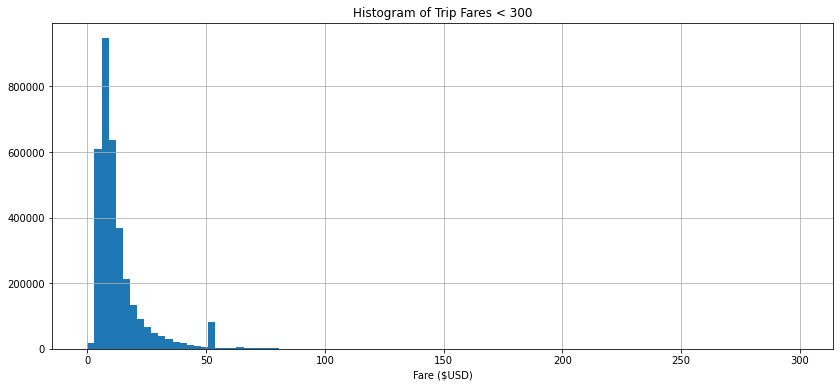

<Figure size 432x288 with 0 Axes>

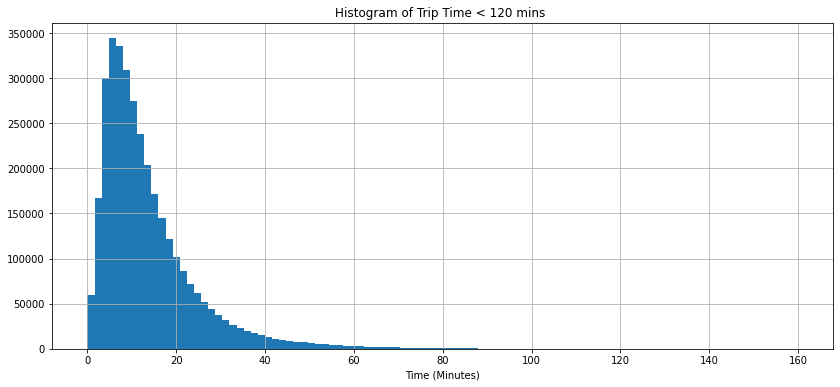

<Figure size 432x288 with 0 Axes>

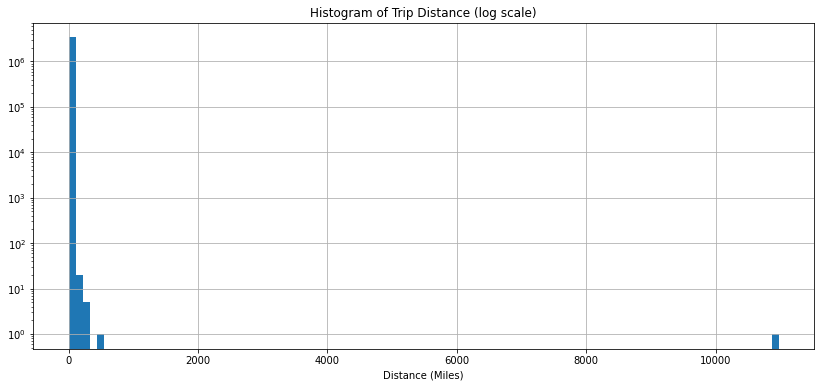

<Figure size 432x288 with 0 Axes>

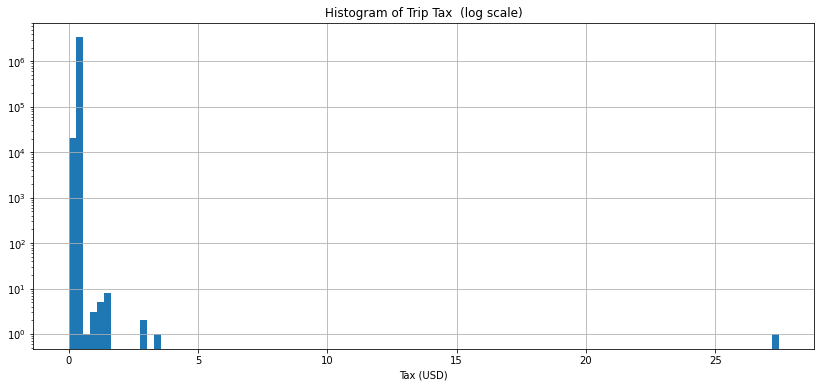

<Figure size 432x288 with 0 Axes>

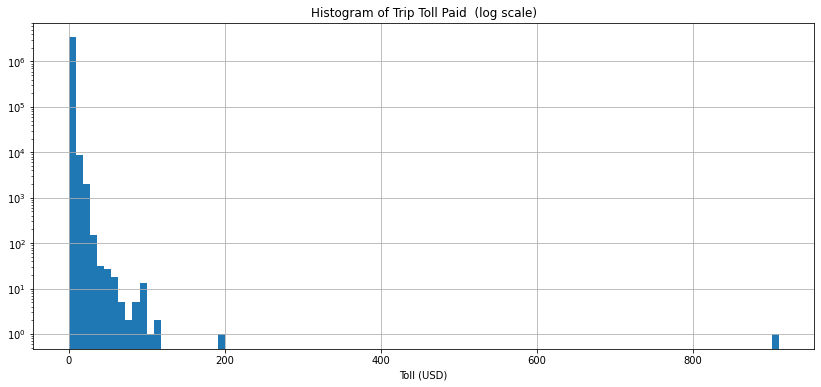

In [ ]:
feature_hist(df[df.fare_amount<300].fare_amount, 'Histogram of Trip Fares < 300', 'Fare ($USD)')
feature_hist(df[df.trip_time < (160)].trip_time, 'Histogram of Trip Time < 120 mins ', 'Time (Minutes)')
feature_hist(df.trip_distance, 'Histogram of Trip Distance', 'Distance (Miles)',  log_scale=True) 
feature_hist(df.mta_tax, 'Histogram of Trip Tax ', 'Tax (USD)', log_scale=True)
feature_hist(df.tolls_amount, 'Histogram of Trip Toll Paid ', 'Toll (USD)', log_scale=True)

These charts provide insights on how we might further clean the data to remove "outliers"?
- Trips with toll > 300 USD ?
- Trip MTA tax > 30 usd ?
- Distance > 150 miles?
- Fare Amount/Trip Time <= 0 or > 300

In [ ]:
# Additional Cleaning
df = df[df.trip_distance < 100]
df = df[df.trip_time < 100]
df = df[df.tolls_amount < 100]
df = df[df.fare_amount < 100]
df = df[df.mta_tax < 30]
df = df[df.year.isin(years)] # remove any years outside current consideration
df = df[df.passenger_count > 0] # remove trips with 0 or less passengers!
df.shape

(3300157, 28)

# Some Modelling 

Features available at trip initiation
- Date - day, week, year, hour, holiday or not 
- Pickup location, Drop off location 
- Payment type ?

In [ ]:
# pd.to_datetime(df['tpep_pickup_datetime'], format='%Y%m%d', errors='coerce').dt.month
df.dtypes 

VendorID                        float64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                    float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
pickup_date_only         datetime64[ns]
dropoff_date_only        datetime64[ns]
holiday                           int64
trip_time                       float64
month                             int64
week                             UInt32
dayofweek                         int64


In [ ]:
train_sample_size = 100000
categorical_features = ["isweekday", "dayofweek","holiday", "PULocationID", "DOLocationID"]  #["PULocationID", "DOLocationID"]
feature_list = ["passenger_count" ,"month","week","hour"]  
dfa = df 
dfa = df.sample(train_sample_size, random_state=42)

dfa[categorical_features] = dfa[categorical_features].astype("category") 
df_data = dfa[feature_list + categorical_features] 

data_ohe = pd.get_dummies(dfa[categorical_features])
df_data_ohe = pd.concat([dfa[feature_list],data_ohe],axis=1) 
# df_data_ohe = df_data
df_data_ohe.columns

# df_data = dfa[feature_list ] 
# df_data[categorical_features] = df_data[categorical_features].astype("category") 

Index(['passenger_count', 'month', 'week', 'hour', 'isweekday_0.0',
       'isweekday_1.0', 'dayofweek_0', 'dayofweek_1', 'dayofweek_2',
       'dayofweek_3',
       ...
       'DOLocationID_256', 'DOLocationID_257', 'DOLocationID_258',
       'DOLocationID_259', 'DOLocationID_260', 'DOLocationID_261',
       'DOLocationID_262', 'DOLocationID_263', 'DOLocationID_264',
       'DOLocationID_265'],
      dtype='object', length=501)

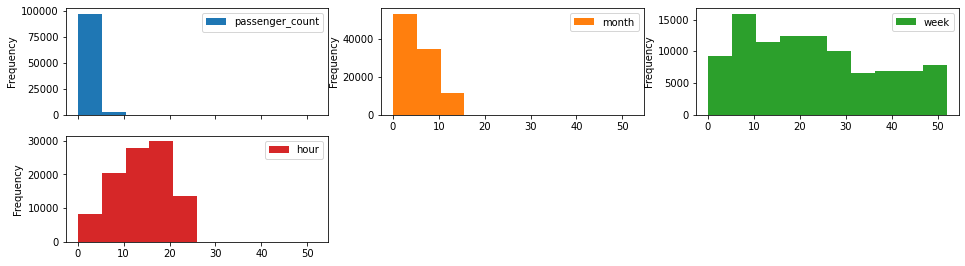

In [ ]:
# plt.figure() 
thist = train_data_hist = df_data.plot.hist(subplots=True, layout=(7,3 ),  figsize=(16,16)) 

In [ ]:
fare_labels = dfa.fare_amount
trip_time_labels = dfa.trip_time
fare_labels.shape, trip_time_labels.shape, df_data.shape, df_data_ohe.shape

((100000,), (100000,), (100000, 9), (100000, 501))

In [ ]:
#@title
import time
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR 
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, mean_squared_log_error


trained_models = [] #  keep track of all details for models we train
def train_model(model, data, labels): 
  X = data.values
  y = labels.values
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

  pipe = Pipeline([('scaler', StandardScaler()),('clf', model["clf"])])
  start_time = time.time()
  pipe.fit(X_train, y_train)
  train_time = time.time() - start_time

  train_preds = pipe.predict(X_train) 
  test_preds = pipe.predict(X_test)

  np.histogram(train_preds)
  np.histogram(test_preds) 

  train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
  test_rmse = np.sqrt(mean_squared_error(y_test, test_preds)) 

  train_mae =  mean_absolute_error(y_train, train_preds)
  test_mae =  mean_absolute_error(y_test, test_preds)

  train_accuracy =  pipe.score(X_train, y_train)
  test_accuracy = pipe.score(X_test, y_test) 

  model_details = {"name": model["name"], 
                   "train_rmse":train_rmse, 
                   "test_rmse":test_rmse, 
                   "train_mae":train_mae, 
                   "test_mae":test_mae, 
                   "train_time": train_time, 
                   "model": pipe,
                   "y_test": y_test,
                   "test_preds": test_preds
                   }
  return model_details

models = [ 
          # {"name": "Linear Regression", "clf": LinearRegression()},
          {"name": "Decision Tree", "clf": DecisionTreeRegressor()},
          {"name": "Random Forest", "clf": RandomForestRegressor(n_estimators=100)},
          {"name": "Gradient Boosting", "clf": GradientBoostingRegressor(n_estimators=100)}, 
          {"name": "MLP Classifier", "clf": MLPRegressor(solver='adam', alpha=1e-1, hidden_layer_sizes=(10,10,5,2), max_iter=500, random_state=42)}
          ]




In [ ]:
def plot_models(trained_models,outcome_type):
  # visualize accuracy and run time
  setup_plot()
  model_df = pd.DataFrame(trained_models)
  model_df.sort_values("test_rmse", inplace=True) 
  ax = model_df[["train_rmse","test_rmse", "name"]].plot(kind="line", x="name", figsize=(19,5), title="Classifier Performance Sorted by Test Accuracy - " + outcome_type)
  ax.legend(["Train RMSE", "Test RMSE"])
  for p in ax.patches:
      ax.annotate( str( round(p.get_height(),3) ), (p.get_x() * 1.005, p.get_height() * 1.005))

  ax.title.set_size(20)
  plt.box(False)

  model_df.sort_values("train_time", inplace=True)
  ax= model_df[["train_time","name"]].plot(kind="line", x="name", figsize=(19,5), grid=True, title="Classifier Training Time (seconds)" + outcome_type)
  ax.title.set_size(20)
  ax.legend(["Train Time"])
  plt.box(False) 


def train_models(models, data, labels, outcome_type):
  for model in models:
    model_details = train_model(model, data, labels) 
    trained_models.append(model_details) 
  
  return trained_models 

trained_models = train_models(models, df_data_ohe, trip_time_labels, "Trip Fare")
# trained_models


RMSE: Train 0.24973247908734483 Test 9.990633553623002
MAE: Train 0.014397333333333333 Test 6.903085666666668


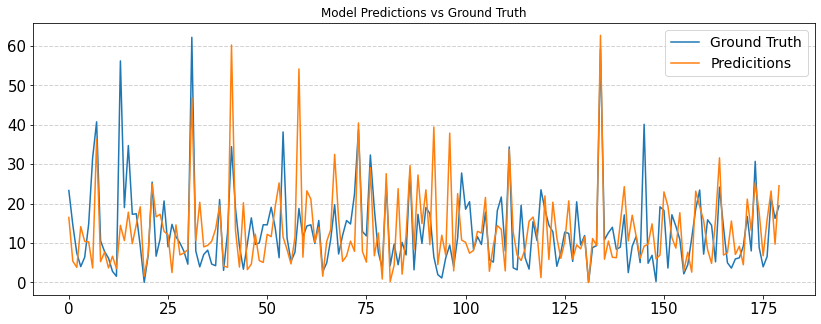

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(trained_models[0]["y_test"][:180] , label="Ground Truth") 
plt.plot(trained_models[0]["test_preds"][:180] , label="Predicitions" )
# plt.legend(handles=["one", "two", "three"])
plt.title("Model Predictions vs Ground Truth")
plt.legend(loc="upper right")

print("RMSE: Train",trained_models[0]["train_rmse"], "Test",trained_models[0]["test_rmse"]  )
print("MAE: Train",trained_models[0]["train_mae"], "Test",trained_models[0]["test_mae"]  )

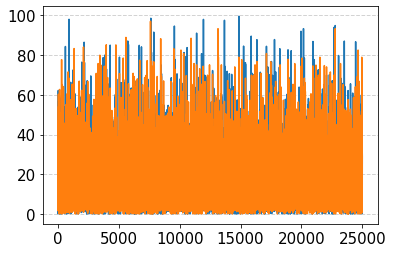

In [ ]:
plt.plot(trained_models[0]["y_test"]  )
plt.plot(trained_models[0]["test_preds"] )

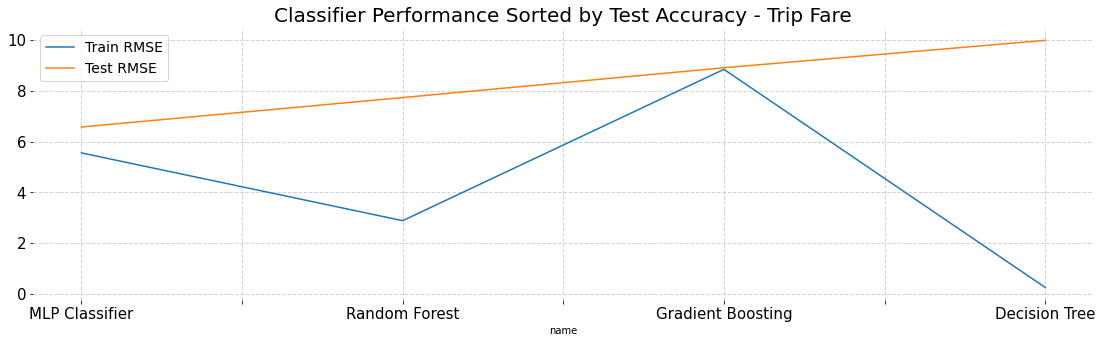

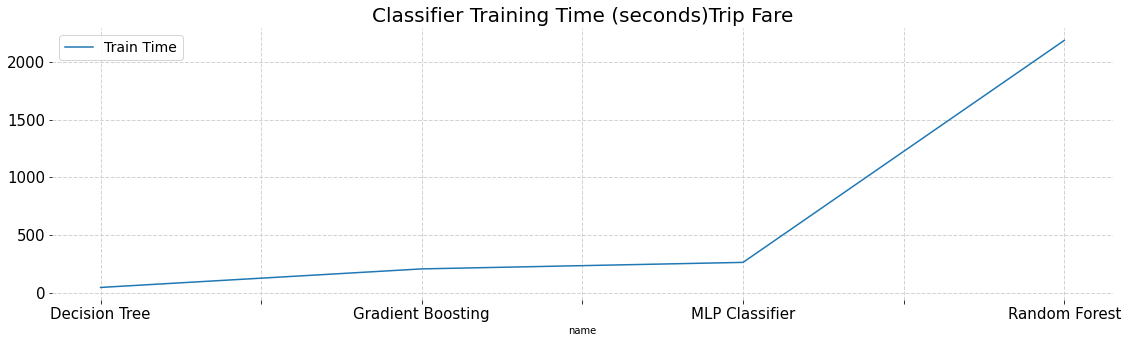

In [ ]:

plot_models(trained_models, "Trip Fare")

In [ ]:
model_df = pd.DataFrame(trained_models)
model_df[["name","train_rmse","test_rmse", "train_mae","test_mae"]]

,name,train_rmse,test_rmse,train_mae,test_mae
0,Decision Tree,0.249732,9.990634,0.014397,6.903086
1,Random Forest,2.882463,7.735134,1.950114,5.282178
2,Gradient Boosting,8.847484,8.910916,6.468980,6.476607
3,MLP Classifier,5.554067,6.574912,3.794174,4.266549


# Analytics and Plots

In [ ]:
import geopandas as gpd
import contextily as ctx

df = gpd.read_file("data/zones/taxi_zones.shp") 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  This is separate from the ipykernel package so we can avoid doing imports until


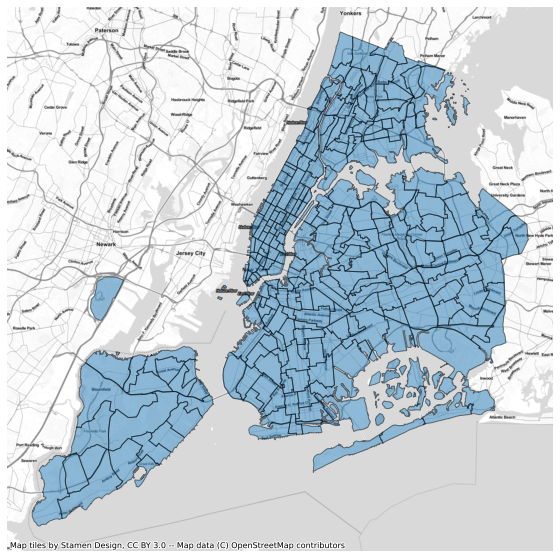

In [ ]:
df = df.to_crs(epsg=3857)
ax = df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, zoom=12, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()